# Dog Inpainting
Uczenie Głębokie - praca domowa<br />
Autorzy:<br />
*Jakub Link 184469*<br />
*Michał Cellmer 184685*<br />
specjalność: Uczenie Maszynowe<br />


In [1]:
import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

c:\Users\micha\miniconda3\envs\dog-inpainting\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pozyskanie danych

In [2]:
cache_path = kagglehub.dataset_download("wutheringwang/dog-face-recognition")
shutil.move(cache_path, "archive")

100%|██████████| 184M/184M [00:21<00:00, 8.93MB/s] 

Extracting model files...


'archive\\1'

## Konfiguracja parametrów

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 64
batch_size = 32
epochs = 20
learning_rate = 1e-3
mask_fraction_range = (0.15, 0.3)

data_dir = "./archive"

## Przetwarzanie wstępne

In [4]:
class DogDataset(Dataset):
    def __init__(self, root_dir):
        self.image_files = []
        for root, _, files in os.walk(root_dir):
            self.image_files.extend([os.path.join(root, f) for f in files if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (image_size, image_size))
        image = image.astype(np.float32) / 255.0

        # Mask generation
        mask = np.zeros((image_size, image_size), dtype=np.float32)
        mask_fraction = np.random.uniform(*mask_fraction_range)
        mask_size = int(image_size * mask_fraction)
        top = np.random.randint(0, image_size - mask_size)
        left = np.random.randint(0, image_size - mask_size)
        mask[top:top + mask_size, left:left + mask_size] = 1

        masked_image = image * (1 - mask)
        return (
            torch.tensor(masked_image).unsqueeze(0),
            torch.tensor(image).unsqueeze(0),
            torch.tensor(mask).unsqueeze(0)
        )

In [5]:
train_dataset = DogDataset(os.path.join(data_dir, "train"))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DogDataset(os.path.join(data_dir, "test_200_single_img"))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Definicja modelu autokodera

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model = Autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Trening

In [8]:
def train_step(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    for masked_images, original_images, masks in tqdm(loader, desc="Training"):
        masked_images = masked_images.to(device)
        original_images = original_images.to(device)
        masks = masks.to(device)

        outputs = model(masked_images)
        loss = loss_fn(outputs * masks, original_images * masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(loader)
    return avg_loss

def val_step(model, loader, loss_fn, device):
    model.eval()
    val_loss = 0.0
    with torch.inference_mode():
        for masked_images, original_images, masks in tqdm(loader, desc="Validation"):
            masked_images = masked_images.to(device)
            original_images = original_images.to(device)
            masks = masks.to(device)

            outputs = model(masked_images)
            loss = loss_fn(outputs * masks, original_images * masks)
            val_loss += loss.item()
    avg_loss = val_loss / len(loader)
    return avg_loss

In [9]:
for epoch in range(epochs):
    avg_train_loss = train_step(model, train_loader, optimizer, loss_fn, device)
    avg_val_loss = val_step(model, val_loader, loss_fn, device)
    print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

Validation: 100%|██████████| 6/6 [00:00<00:00, 14.49it/s]


Epoch [1/20], Training Loss: 0.0010, Validation Loss: 0.0011


Validation: 100%|██████████| 6/6 [00:00<00:00, 20.34it/s]


Epoch [2/20], Training Loss: 0.0007, Validation Loss: 0.0008


Validation: 100%|██████████| 6/6 [00:00<00:00, 12.06it/s]


Epoch [3/20], Training Loss: 0.0007, Validation Loss: 0.0007


Validation: 100%|██████████| 6/6 [00:00<00:00, 29.59it/s]


Epoch [4/20], Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.38it/s]


Epoch [5/20], Training Loss: 0.0006, Validation Loss: 0.0006


Validation: 100%|██████████| 6/6 [00:00<00:00, 30.22it/s]


Epoch [6/20], Training Loss: 0.0006, Validation Loss: 0.0006


Validation: 100%|██████████| 6/6 [00:00<00:00, 20.44it/s]


Epoch [7/20], Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 6/6 [00:00<00:00, 23.09it/s]


Epoch [8/20], Training Loss: 0.0006, Validation Loss: 0.0006


Validation: 100%|██████████| 6/6 [00:00<00:00, 10.81it/s]


Epoch [9/20], Training Loss: 0.0006, Validation Loss: 0.0006


Validation: 100%|██████████| 6/6 [00:00<00:00, 23.16it/s]


Epoch [10/20], Training Loss: 0.0006, Validation Loss: 0.0006


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.20it/s]


Epoch [11/20], Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 6/6 [00:00<00:00, 18.20it/s]


Epoch [12/20], Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 6/6 [00:00<00:00, 19.04it/s]


Epoch [13/20], Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 6/6 [00:00<00:00, 17.13it/s]


Epoch [14/20], Training Loss: 0.0006, Validation Loss: 0.0006


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.93it/s]


Epoch [15/20], Training Loss: 0.0005, Validation Loss: 0.0006


Validation: 100%|██████████| 6/6 [00:00<00:00, 17.10it/s]


Epoch [16/20], Training Loss: 0.0005, Validation Loss: 0.0006


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.96it/s]


Epoch [17/20], Training Loss: 0.0005, Validation Loss: 0.0006


Validation: 100%|██████████| 6/6 [00:00<00:00, 23.10it/s]


Epoch [18/20], Training Loss: 0.0005, Validation Loss: 0.0006


Validation: 100%|██████████| 6/6 [00:00<00:00, 20.29it/s]


Epoch [19/20], Training Loss: 0.0005, Validation Loss: 0.0006


Validation: 100%|██████████| 6/6 [00:00<00:00, 20.08it/s]

Epoch [20/20], Training Loss: 0.0005, Validation Loss: 0.0006


## Wizualizacja kilku próbek walidacyjnych

In [17]:
def inpaint_image(model, image, mask):
    model.eval()
    with torch.inference_mode():
        output = model(image.unsqueeze(0).to(device))
        inpainted_image = output.squeeze(0).cpu()
        result = image * (1 - mask) + inpainted_image * mask
        return inpainted_image, result

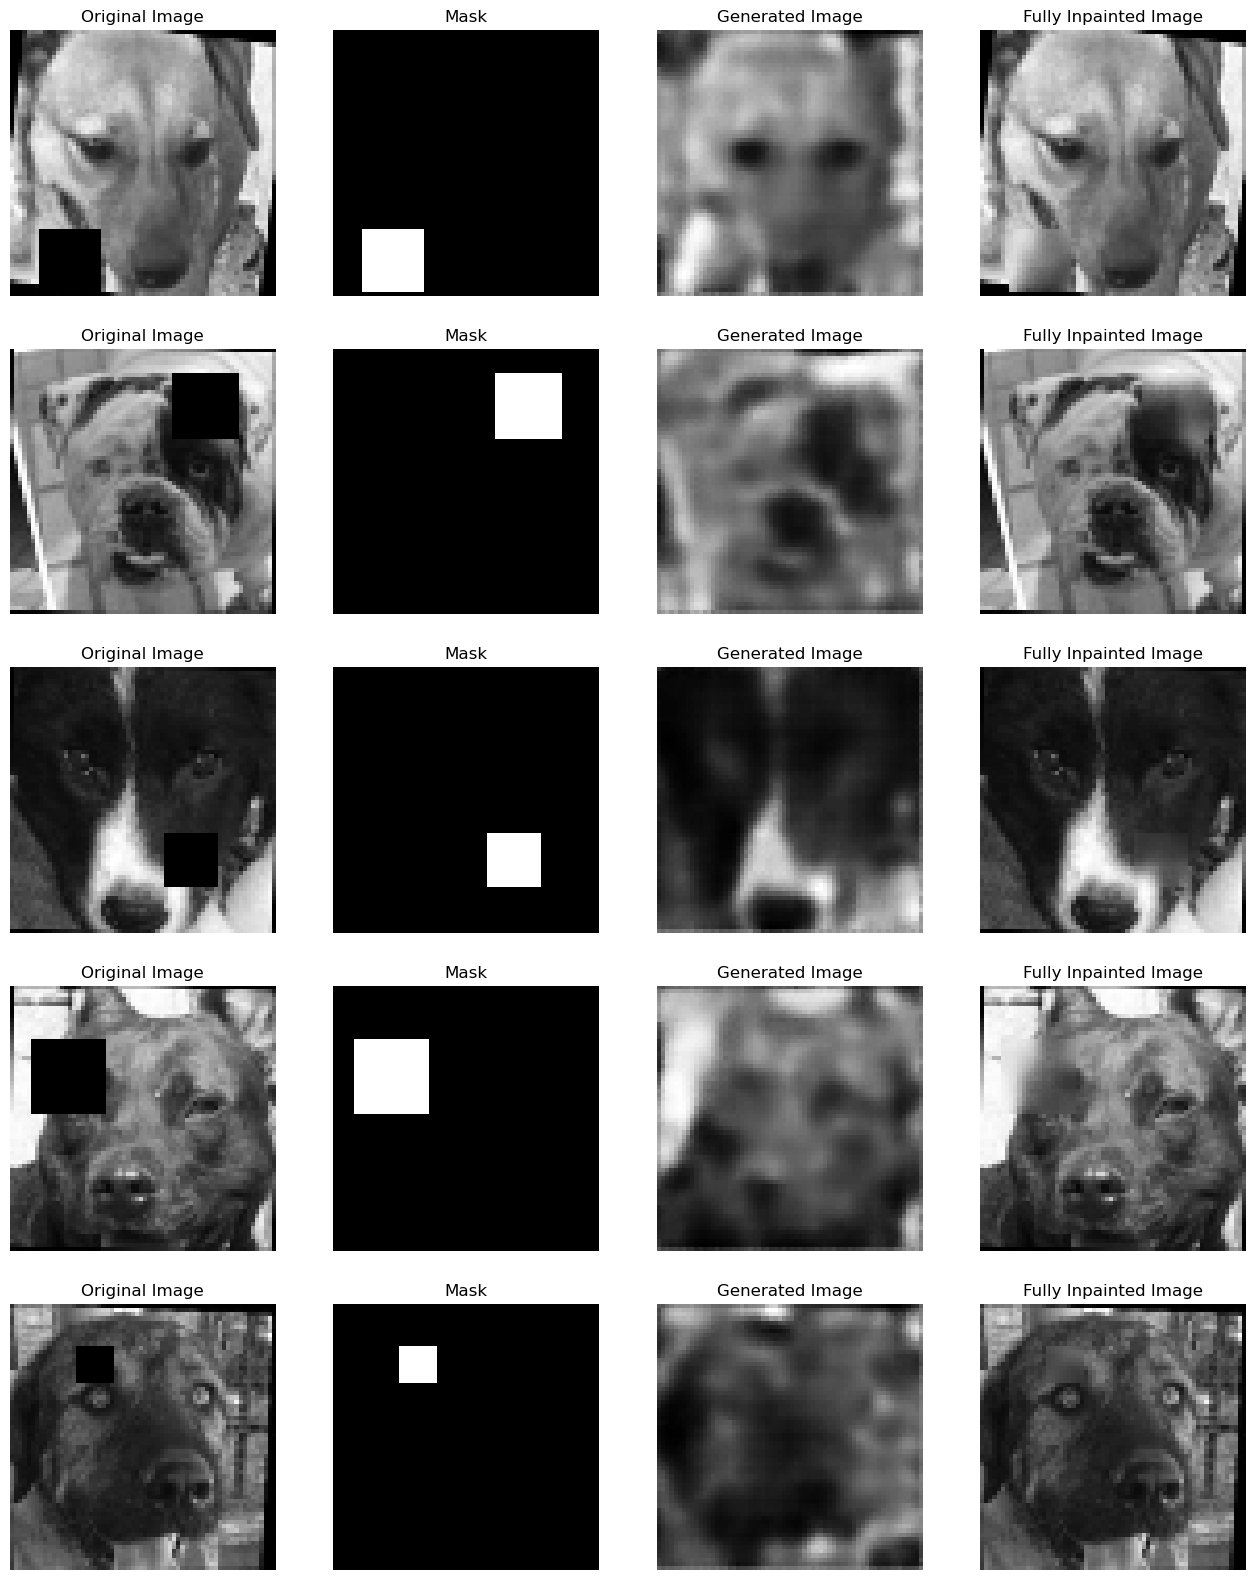

In [27]:
n_samples = 5
random_samples = random.sample(list(val_dataset), n_samples)

plt.figure(figsize=(16, 20))

for row_idx, (test_image, _, test_mask) in enumerate(random_samples):
    inpainted_image, inpainted_result = inpaint_image(model, test_image.squeeze(), test_mask)

    plt.subplot(5, 4, row_idx * 4 + 1)
    plt.imshow(test_image.squeeze().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 4, row_idx * 4 + 2)
    plt.imshow(test_mask.squeeze().numpy(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(5, 4, row_idx * 4 + 3)
    plt.imshow(inpainted_image.squeeze().numpy(), cmap='gray')
    plt.title('Generated Image')
    plt.axis('off')

    plt.subplot(5, 4, row_idx * 4 + 4)
    plt.imshow(inpainted_result.squeeze().numpy(), cmap='gray')
    plt.title('Fully Inpainted Image')
    plt.axis('off')

plt.show()

## Wizualizacja przykładów

In [19]:
class EvalDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_files = []
        self.mask_files = []
        
        for root, _, files in os.walk(image_dir):
            self.image_files.extend([os.path.join(root, f) for f in files if f.endswith('.jpg')])
        for root, _, files in os.walk(mask_dir):
            self.mask_files.extend([os.path.join(root, f) for f in files if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):  
        img_path = self.image_files[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (image_size, image_size))
        image = image.astype(np.float32) / 255.0

        mask_path = self.mask_files[idx]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (image_size, image_size))
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask = mask.astype(np.float32) / 255.0

        masked_image = image * (1 - mask)
        return (
            torch.tensor(masked_image).unsqueeze(0),
            torch.tensor(image).unsqueeze(0),
            torch.tensor(mask).unsqueeze(0)
        )

In [20]:
eval_dataset = EvalDataset(os.path.join("tests_dogs", "images_dogs"), os.path.join("tests_dogs", "masks_dogs"))
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

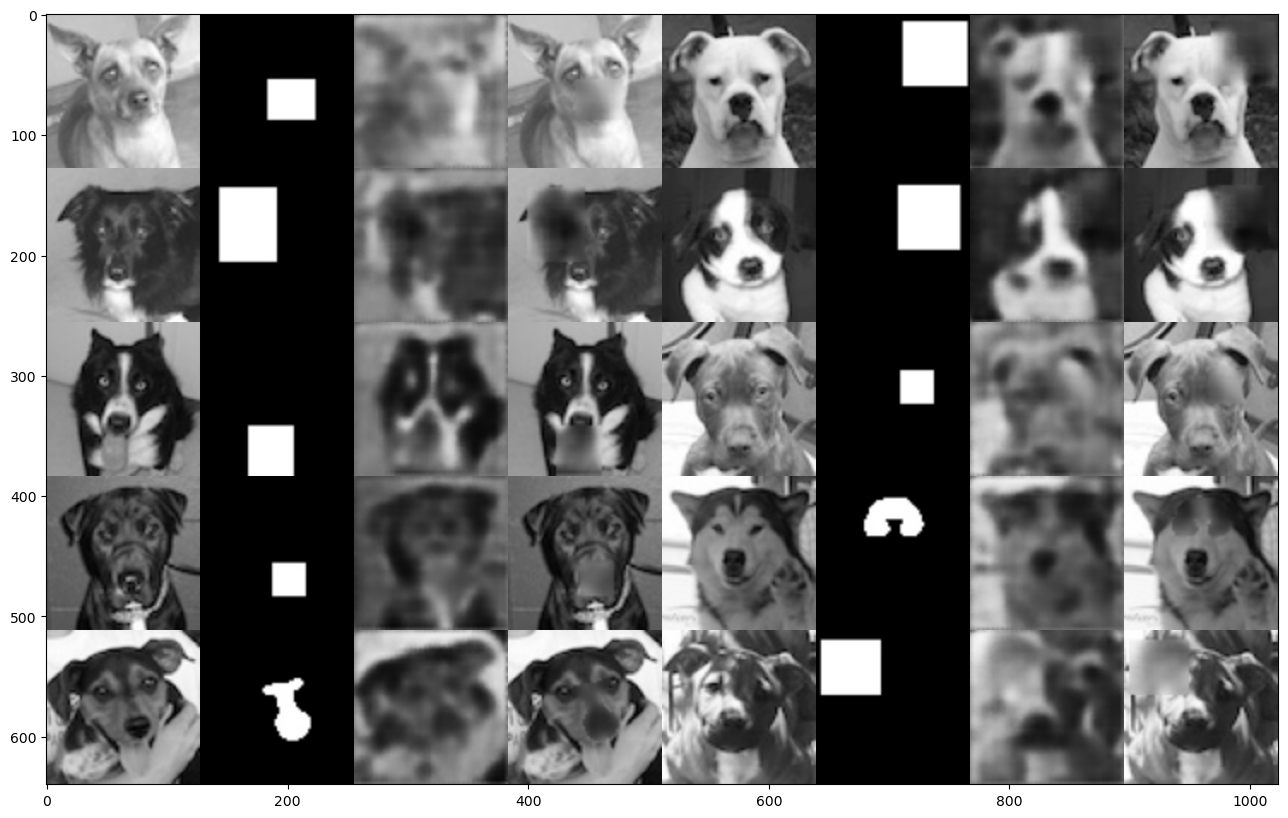

In [21]:
present_size = 128
presentation = np.zeros((present_size*5, present_size*8, 1), dtype=np.float32)

for idx, (masked_raw, raw, mask) in enumerate(eval_loader):
    generated, combined = inpaint_image(model, masked_raw.squeeze(), mask)
    
    left = (idx % 2) * present_size * 4
    top = (idx // 2) * present_size
    
    presentation[top:top+present_size, left:left+present_size, :] = cv2.resize(raw.squeeze().cpu().numpy(), (present_size, present_size)).reshape((present_size, present_size, 1))
    presentation[top:top+present_size, left+present_size:left+2*present_size, :] = cv2.resize(mask.squeeze().cpu().numpy(), (present_size, present_size)).reshape((present_size, present_size, 1))
    presentation[top:top+present_size, left+2*present_size:left+3*present_size, :] = cv2.resize(generated.squeeze().cpu().numpy(), (present_size, present_size)).reshape((present_size, present_size, 1))
    presentation[top:top+present_size, left+3*present_size:left+4*present_size, :] = cv2.resize(combined.squeeze().cpu().numpy(), (present_size, present_size)).reshape((present_size, present_size, 1))

cv2.imwrite("tests_dogs.jpg", presentation.reshape((present_size*5, present_size*8))*255.)
plt.figure(figsize=(16, 10))
plt.imshow(cv2.imread("tests_dogs.jpg"))
plt.show()